# Import Library

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler


import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

ETH_USD_2016-12-17_2021-12-29-CoinDesk## Import dataset

In [ ]:
# The dataset in local machine
root_path = 'ETH_USD_2020-03-29-CoinDesk.csv'

# read data
eth_input_df = pd.read_csv(root_path)

## Data Exploration

In [ ]:
eth_input_df.tail()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
362,ETH,2020-03-21,131.753158,140.821846,153.143981,116.607633
363,ETH,2020-03-22,133.081686,131.764958,137.809286,126.069195
364,ETH,2020-03-23,123.273947,133.056976,137.605356,122.309624
365,ETH,2020-03-24,133.570141,122.479152,137.889611,119.742646
366,ETH,2020-03-25,140.113700,133.575579,144.326815,133.078218


In [ ]:
eth_input_df.shape

(367, 6)

In [ ]:
eth_input_df.describe()

,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
count,367.000000,367.000000,367.000000,367.000000
mean,194.294643,194.242148,200.346855,184.380535
std,47.695586,47.761574,49.830018,43.163361
min,107.898345,107.906358,119.068575,89.122036
25%,162.738970,162.396868,167.432785,157.100765
50%,182.106743,181.728338,186.312340,176.974300
75%,224.134093,223.705423,231.825235,209.820753
max,324.130855,324.152287,363.053164,314.152031


In [ ]:
eth_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             367 non-null    object 
 1   Date                 367 non-null    object 
 2   Closing Price (USD)  367 non-null    float64
 3   24h Open (USD)       367 non-null    float64
 4   24h High (USD)       367 non-null    float64
 5   24h Low (USD)        367 non-null    float64
dtypes: float64(4), object(2)
memory usage: 17.3+ KB


## Etherium Current prices

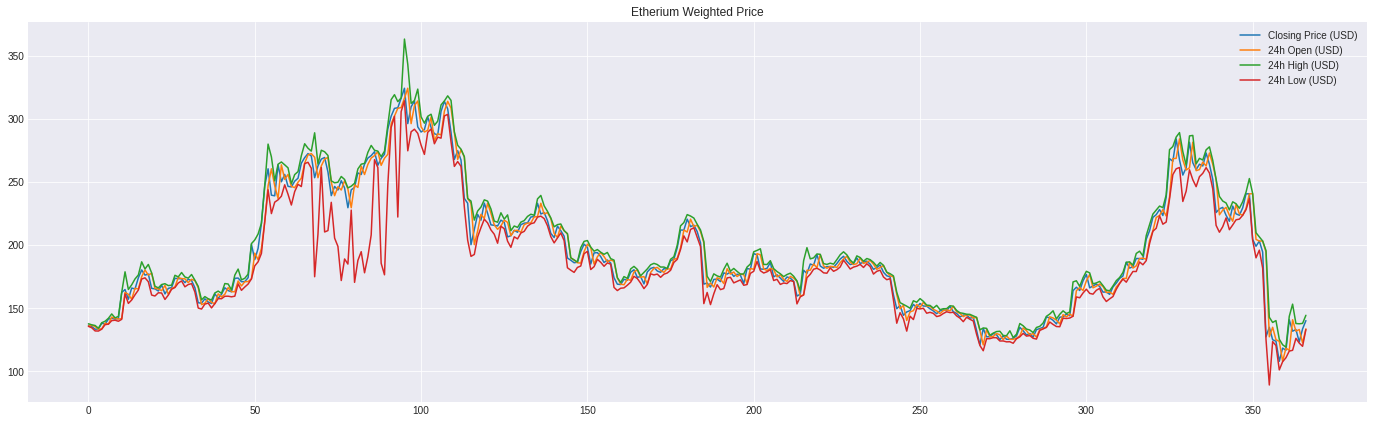

In [ ]:
eth_input_df.plot(figsize=(24,7), title="Etherium Weighted Price")

#### Group the data by date

In [ ]:
display(eth_input_df.head())
group = eth_input_df.groupby('Date')
#display(group.head())
eth_closing_price_groupby_date = group['Closing Price (USD)'].mean()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,ETH,2019-03-24,136.449900,135.709843,137.606598,135.541305
1,ETH,2019-03-25,135.398581,136.449900,136.781789,134.453531
2,ETH,2019-03-26,133.302631,135.398713,136.242951,131.948549
3,ETH,2019-03-27,133.491076,133.302631,134.045312,131.846082
4,ETH,2019-03-28,138.070098,133.606848,138.439679,133.350283


In [ ]:
display(eth_closing_price_groupby_date.tail(10))
print("Length of eth_closing_price_groupby_date :", len(eth_closing_price_groupby_date))

Date
2020-03-16    123.785109
2020-03-17    107.898345
2020-03-18    118.342404
2020-03-19    116.606598
2020-03-20    140.814546
2020-03-21    131.753158
2020-03-22    133.081686
2020-03-23    123.273947
2020-03-24    133.570141
2020-03-25    140.113700
Name: Closing Price (USD), dtype: float64

Length of eth_closing_price_groupby_date : 367


# Train Test Split

In [ ]:
prediction_days = 60

# Set Train data  ( Total data length - prediction_days )
df_train= eth_closing_price_groupby_date[:len(eth_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)

# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= eth_closing_price_groupby_date[len(eth_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [ ]:
df_test.shape

(60, 1)

# Scaling Data between 0 and 1


In [ ]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [ ]:
def dataset_generator_lstm(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)
testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (302, 5)
trainY:  (302,)
testX:  (55, 5)
testY (55,)


### First check the current shape of trainX and testX

In [ ]:
print(trainX.shape)
print(testX.shape)

(302, 5)
(55, 5)


### For LSTM Reshape input ( trainX and testX ) to be 3-D of [samples, time steps, features] and reshape trainX and testX 

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))
print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (302, 5, 1)
Shape of testX:  (55, 5, 1)


## Creating LSTM Model

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 5, 128)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
checkpoint_path = 'my_best_model.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

callbacks = [checkpoint]

history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 600, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/600
 6/10 [=================>............] - ETA: 0s - loss: 0.2013 
Epoch 1: val_loss improved from inf to 0.15846, saving model to my_best_model.hdf5
10/10 [==============================] - 4s 82ms/step - loss: 0.1336 - val_loss: 0.1585
Epoch 2/600
 6/10 [=================>............] - ETA: 0s - loss: 0.0642
Epoch 2: val_loss improved from 0.15846 to 0.03616, saving model to my_best_model.hdf5
10/10 [==============================] - 0s 18ms/step - loss: 0.0480 - val_loss: 0.0362
Epoch 3/600
 6/10 [=================>............] - ETA: 0s - loss: 0.0185
Epoch 3: val_loss improved from 0.03616 to 0.03233, saving model to my_best_model.hdf5
10/10 [==============================] - 0s 18ms/step - loss: 0.0229 - val_loss: 0.0323
Epoch 4/600
10/10 [==============================] - ETA: 0s - loss: 0.0124
Epoch 4: val_loss did not improve from 0.03233
10/10 [==============================] - 0s 15ms/step - loss: 0.0124 - val_loss: 0.0391
Epoch 5/600
 6/10 [=================>..

In [ ]:
from tensorflow.keras.models import load_model
model_from_saved_checkpoint = load_model(checkpoint_path)

In [ ]:
# Transformation to original form and making the predictions
predicted_eth_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_eth_price_test_data = scaler_test.inverse_transform(predicted_eth_price_test_data.reshape(-1, 1))
test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

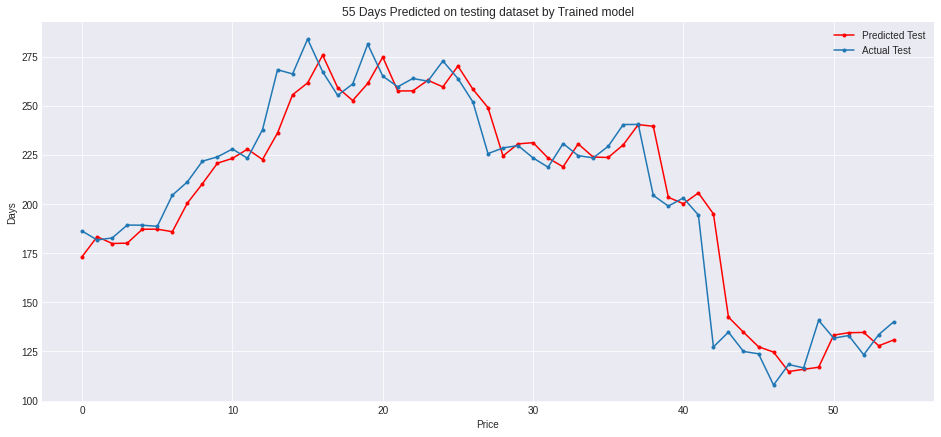

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(predicted_eth_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.xlabel("Price")
plt.ylabel("Days")
plt.title("55 Days Predicted on testing dataset by Trained model")
plt.legend()
plt.show()

# LSTM Prediction using trainX and plotting line graph against Actual trainY

In [ ]:
# Transformation to original form and making the predictions
predicted_eth_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_eth_price_train_data = scaler_train.inverse_transform(predicted_eth_price_train_data.reshape(-1, 1))
train_actual = scaler_train.inverse_transform(trainY.reshape(-1, 1))

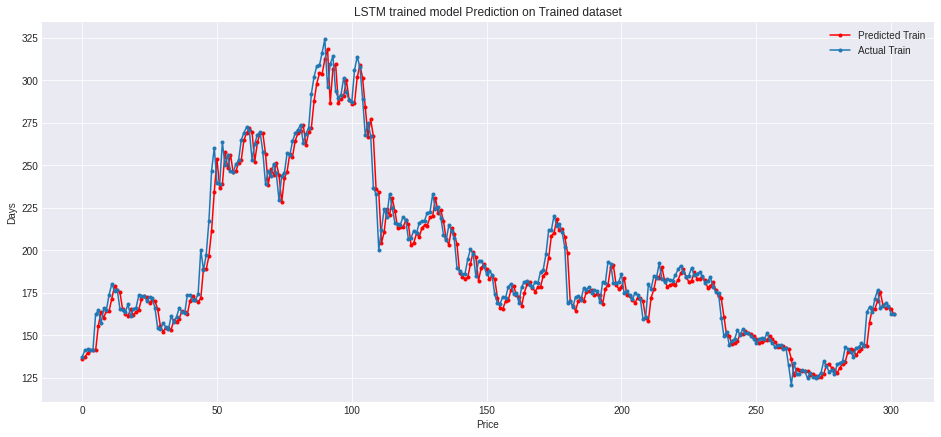

In [ ]:
plt.figure(figsize=(16,7))
plt.plot(predicted_eth_price_train_data, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train')
plt.xlabel("Price")
plt.ylabel("Days")
plt.title("LSTM trained model Prediction on Trained dataset")
plt.legend()
plt.show()

# RMSE - Test Data

In [ ]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_eth_price_test_data))
print('Test RMSE: %.3f' % rmse_lstm_test)

Test RMSE: 14.756


# RMSE - Train Data

In [ ]:
rmse_lstm_train = math.sqrt(mean_squared_error(train_actual, predicted_eth_price_train_data))
print('Test RMSE: %.3f' % rmse_lstm_train)

Test RMSE: 8.379


# Now Future Price Predictions - For 5 Days 

In [ ]:
testX
testX.shape

(55, 5, 1)

In [ ]:
lookback_period = 5
testX_last_5_days = testX[testX.shape[0] - lookback_period :  ]
testX_last_5_days.shape

(5, 5, 1)

In [ ]:
#testX_last_5_days

In [ ]:
predicted_5_days_forecast_price_test_x = []
for i in range(5):  
    predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_5_days[i:i+1])
    predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
    predicted_5_days_forecast_price_test_x.append(predicted_forecast_price_test_x)
    
print("Forecast for the next 5 Days Beyond the actual trading days ", np.array(predicted_5_days_forecast_price_test_x)) 

Forecast for the next 5 Days Beyond the actual trading days  [[[133.2854 ]]

 [[134.51982]]

 [[134.66331]]

 [[127.87289]]

 [[130.85515]]]


In [ ]:
predicted_5_days_forecast_price_test_x = np.array(predicted_5_days_forecast_price_test_x)
#predicted_5_days_forecast_price_test_x.shape

In [ ]:
predicted_5_days_forecast_price_test_x = predicted_5_days_forecast_price_test_x.flatten()
predicted_5_days_forecast_price_test_x

array([133.2854 , 134.51982, 134.66331, 127.87289, 130.85515],
      dtype=float32)

In [ ]:
predicted_eth_price_test_data = predicted_eth_price_test_data.flatten()
predicted_eth_price_test_data.shape

(55,)

In [ ]:
predicted_eth_test_concatenated = np.concatenate((predicted_eth_price_test_data, predicted_5_days_forecast_price_test_x))
predicted_eth_test_concatenated
predicted_eth_test_concatenated.shape

(60,)

# Final Prediction Inculding 5 days

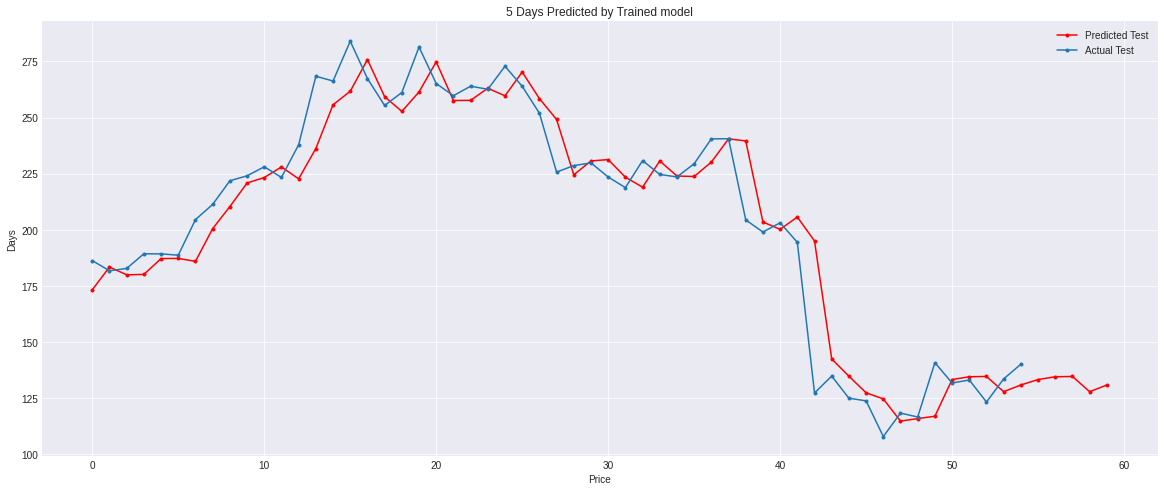

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(predicted_eth_test_concatenated, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.xlabel("Price")
plt.ylabel("Days")
plt.title("5 Days Predicted by Trained model")
plt.legend()
plt.show()